<a href="https://colab.research.google.com/github/Brandon-lz/master/blob/main/aicodes/14%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/CIFAR100%E4%B8%8EVGG10%E5%AE%9E%E6%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR100数据集包含十个大类，每个大类分十个小类，所以是100类，这里用卷积神经网络进行分类实战

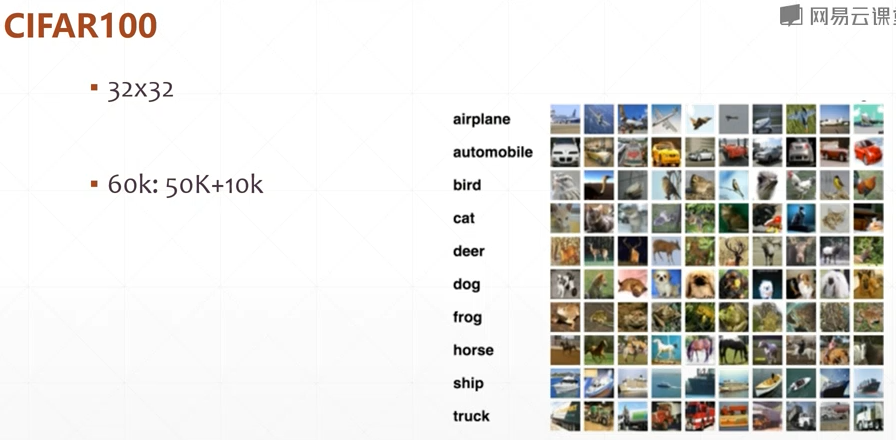

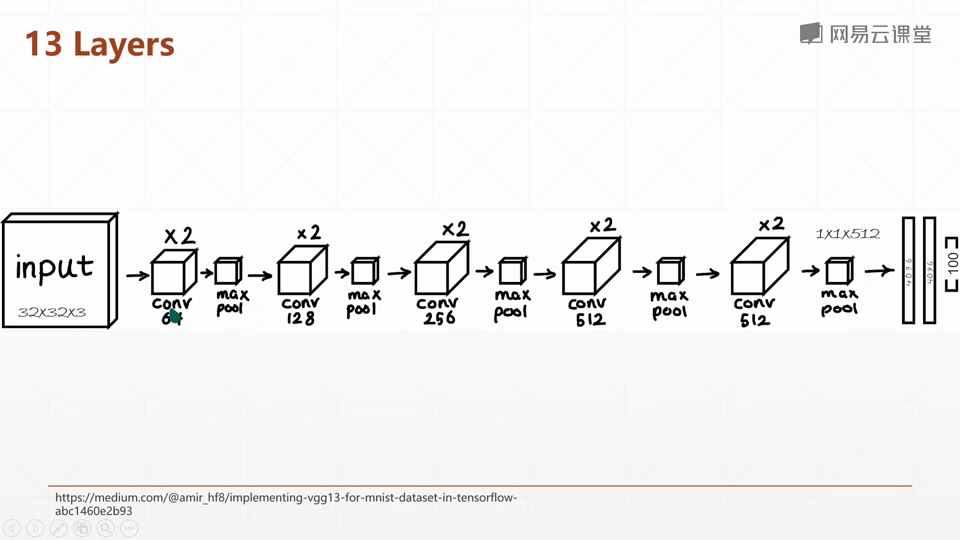

上面的卷积神经网络从左到右分别是两个卷积层，一个下采样层，两个卷积层，一个下采样层...最后是三个全连接层，也就是说实际算下来共有18层网络

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, datasets, Sequential
import os

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.random.set_seed(2345)

In [ ]:
#建立卷积网络层
conv_layers = [
    layers.Conv2D(64, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),      #第一个参数为核数，它决定了输出的数据最后一个维度的通道数，注意这里也用了relu激活函数
    layers.Conv2D(64, kernel_size=[3, 3],  padding="same", activation=tf.nn.relu),     #第二个参数为核的面积，这里用3×3，一般有1、3、5
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),                 #下采样

    layers.Conv2D(128, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),     
    layers.Conv2D(128, kernel_size=[3, 3],  padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),

    layers.Conv2D(256, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),     
    layers.Conv2D(256, kernel_size=[3, 3],  padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),

    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),     
    layers.Conv2D(512, kernel_size=[3, 3],  padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),

    layers.Conv2D(512, kernel_size=[3, 3], padding="same", activation=tf.nn.relu),     
    layers.Conv2D(512, kernel_size=[3, 3],  padding="same", activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
]

In [ ]:
def preprocess(x,y):

  #归一化
  x = tf.cast(x,dtype=tf.float32)/255.
  
  y = tf.cast(y,dtype=tf.int32)
  return x,y

In [ ]:
(x,y),(x_test,y_test) = datasets.cifar100.load_data()
x.shape,y.shape,x_test.shape,y_test.shape,tf.reduce_max(y),tf.reduce_min(y)

((50000, 32, 32, 3),
 (50000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 <tf.Tensor: shape=(), dtype=int64, numpy=99>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

In [ ]:
y = tf.squeeze(y,axis=1)    #把1维度挤压掉
y_test = tf.squeeze(y_test,axis=1)
y_test

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([49, 33, 72, ..., 51, 42, 70])>

In [ ]:
#数据分块
train_db = tf.data.Dataset.from_tensor_slices((x,y))
train_db = train_db.shuffle(1000).map(preprocess).batch(128)      #先打乱顺序，然后预处理，最后切分为64张为一个单位的数据

test_db = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_db = test_db.map(preprocess).batch(64)

In [ ]:
#拿出一块数据看下结构
sample = next(iter(train_db))
len(sample), sample[0].shape, sample[1].shape, tf.reduce_min(sample[0]), tf.reduce_max(sample[0])

(2,
 TensorShape([128, 32, 32, 3]),
 TensorShape([128]),
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
def main():
  #[b,32,32,3]=>[b,1,1,512]     将图片位置信息转化到一维的512通道数据中
  conv_net = Sequential(conv_layers)
  conv_net.build(input_shape=[None,32,32,3])
  '''
  x = tf.random.normal([4,32,32,3])
  out = conv_net(x)
  print(out.shape)
  '''

  #创建全连接层
  fc_net = Sequential([
      layers.Dense(256,activation=tf.nn.relu),
      layers.Dense(128,activation=tf.nn.relu),
      layers.Dense(100,activation=None)
  ])

  fc_net.build(input_shape=[None,512])

  optimizer = optimizers.Adam(lr=1e-4)

  #将所有参数放在一起，方便后面求梯度
  trainable_variables = conv_net.trainable_variables + fc_net.trainable_variables

  #训练50次
  for epoch in range(50):

    for step,(x,y) in enumerate(train_db):
      with tf.GradientTape() as tape:
        #[b,32,32,3] => [b,1,1,512]
        out = conv_net(x)
        #[b,512]
        out = tf.reshape(out,[-1,512])

        #[b,512] => [b,100]
        logits = fc_net(out)
        y_onehot = tf.one_hot(y, depth=100)

        loss = tf.losses.categorical_crossentropy(y_onehot,logits,from_logits=True)
        loss = tf.reduce_mean(loss)
      
      #对超参数求导
      grads = tape.gradient(loss,trainable_variables)
      #使用优化器更新超参数
      optimizer.apply_gradients(zip(grads,trainable_variables))

      if step%100 ==0 :
        print(epoch,step,'loss',loss.numpy())
    
    total_correct=0
    total_num=0
    for x,y in test_db:
      out = conv_net(x)
      out = tf.reshape(out,[-1,512])
      logits = fc_net(out)
      prob = tf.nn.softmax(logits,axis=1)    #probability
      pred = tf.argmax(prob,axis=1)      #predict
      pred = tf.cast(pred,dtype=tf.int32)

      correct = tf.cast(tf.equal(pred,y),dtype=tf.int32)    #比较对的次数
      correct = tf.reduce_sum(correct)

      total_num += x.shape[0]
      total_correct += int(correct)

    acc = total_correct/total_num
    print(epoch,step,'acc:',acc)
    

main()

0 0 loss 4.605704
0 100 loss 4.5808907
0 200 loss 4.2524815
0 300 loss 4.257986
0 390 acc: 0.0732
1 0 loss 4.035369
1 100 loss 4.0024896
1 200 loss 3.9030252
1 300 loss 3.9473135
1 390 acc: 0.1119
2 0 loss 3.909882
2 100 loss 3.8187008
2 200 loss 3.65185
2 300 loss 3.3984427
2 390 acc: 0.1645
3 0 loss 3.6199203
3 100 loss 3.6199312
3 200 loss 3.245448
3 300 loss 3.0792646
3 390 acc: 0.2008
4 0 loss 3.4428601
4 100 loss 3.2868383
4 200 loss 3.2450542
4 300 loss 3.1830935
4 390 acc: 0.2219
5 0 loss 3.2101922
5 100 loss 2.9373918
5 200 loss 2.8729362
5 300 loss 2.9104218
5 390 acc: 0.2494
6 0 loss 2.9255047
6 100 loss 3.0453796
6 200 loss 2.7897825
6 300 loss 3.1153736
6 390 acc: 0.2791
7 0 loss 2.9267929
7 100 loss 2.6994853
7 200 loss 2.5419834
7 300 loss 2.5686572
7 390 acc: 0.2869
8 0 loss 2.6125753
8 100 loss 2.596239
8 200 loss 2.670371
8 300 loss 2.6775804
8 390 acc: 0.311
9 0 loss 2.6697648
9 100 loss 2.4113333
9 200 loss 2.5886831
9 300 loss 2.131881
9 390 acc: 0.3179
10 0 loss 2

我们发现用这种方法判断出来的结果准确率非常有限，除了网络结构的问题，数据集本身也比较简单，分出来的类又多，学习结果一般也正常